In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils

In [ ]:
os.chdir('/home/walml/repos/agnfinder')

In [45]:

# save_dir = 'results/emulated_sampling/real'
save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'

galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')[:1]
assert galaxy_locs


# open one galaxy for params
with h5py.File(galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
            if f['is_accepted'][...].mean() < 0.6:
                print(f['is_accepted'])
            else:
                galaxies.append({
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples']),
                    'name': galaxy_loc.split('_')[-2],
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
#                     'redshift': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...]
                })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [46]:
galaxy = galaxies[0]

In [47]:
galaxy['samples'].shape

(80000, 8)

In [48]:
len(params)

8

In [49]:
import corner

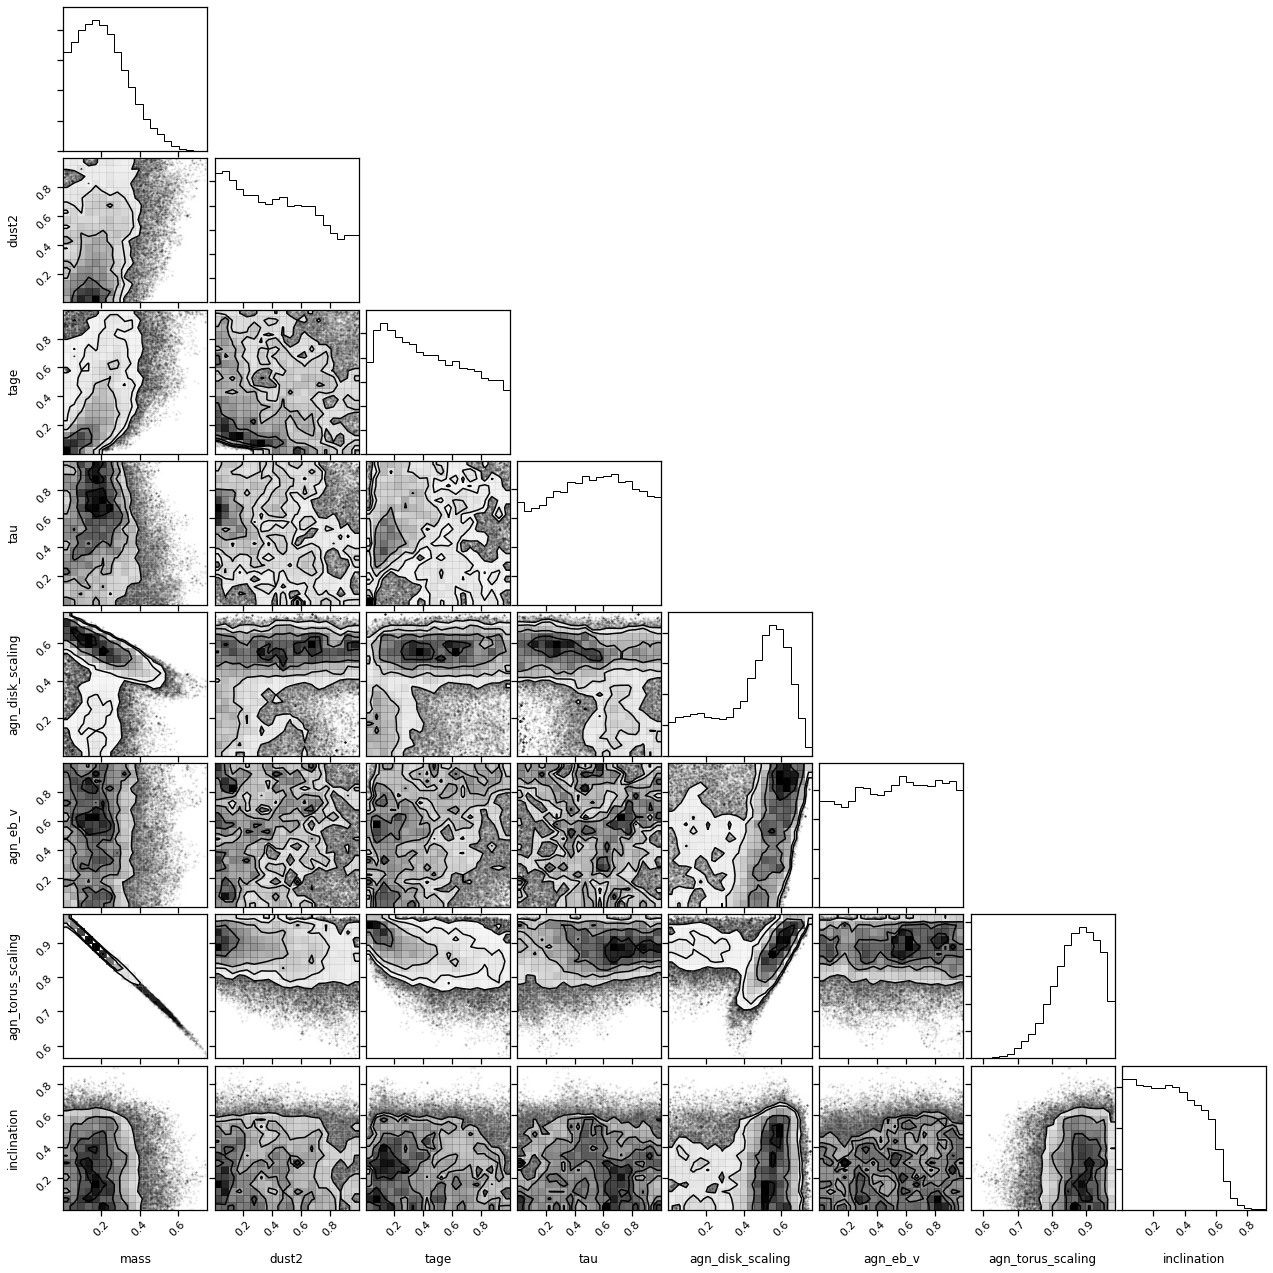

In [50]:
_ = corner.corner(galaxy['samples'], labels=params)

In [ ]:
data = []
for chain_n, chain in enumerate(samples_by_chain):
    for sample_n, sample in enumerate(chain):
        series = dict(zip(param_names, sample))
        series['chain'] = chain_n
        series['sample'] = sample_n
        data.append(series)

In [51]:
import arviz as az

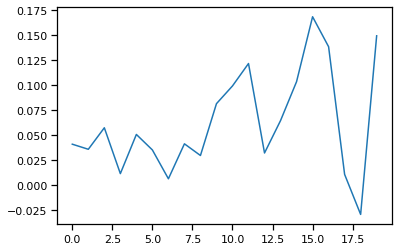

In [52]:
geweke = az.geweke(galaxy['samples'])
geweke.shape
plt.plot(geweke[:, 1])

In [56]:
samples = galaxy['samples']
true_params = galaxy['true_params']

In [63]:
ds = az.convert_to_dataset(np.expand_dims(samples, axis=0), coords=dict(zip(params, range(len(params)))))  # first 5 chains, for clarity

In [64]:
ds

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 80000, x_dim_0: 8)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 79994 79995 79996 79997 79998 79999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (chain, draw, x_dim_0) float32 0.17613171 0.05090337 ... 0.45758998
Attributes:
    created_at:  2020-02-09T19:15:49.038800

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning:Argume

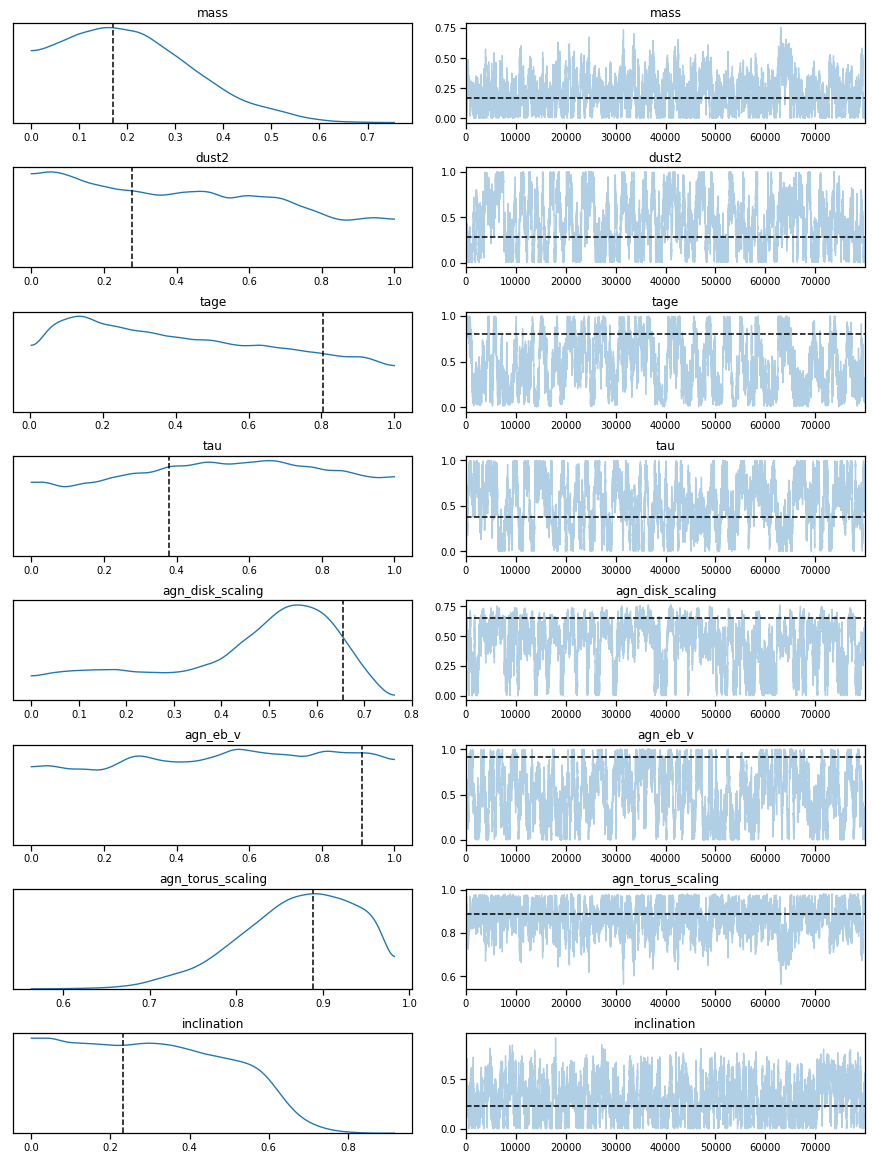

In [65]:
axes = az.plot_trace(ds)  
for param_n in range(len(true_params)):
    axes[param_n][0].set_title(params[param_n])
    axes[param_n][1].set_title(params[param_n])
    axes[param_n][0].axvline(true_params[param_n], linestyle='--', color='k')
    axes[param_n][1].axhline(true_params[param_n], linestyle='--', color='k')

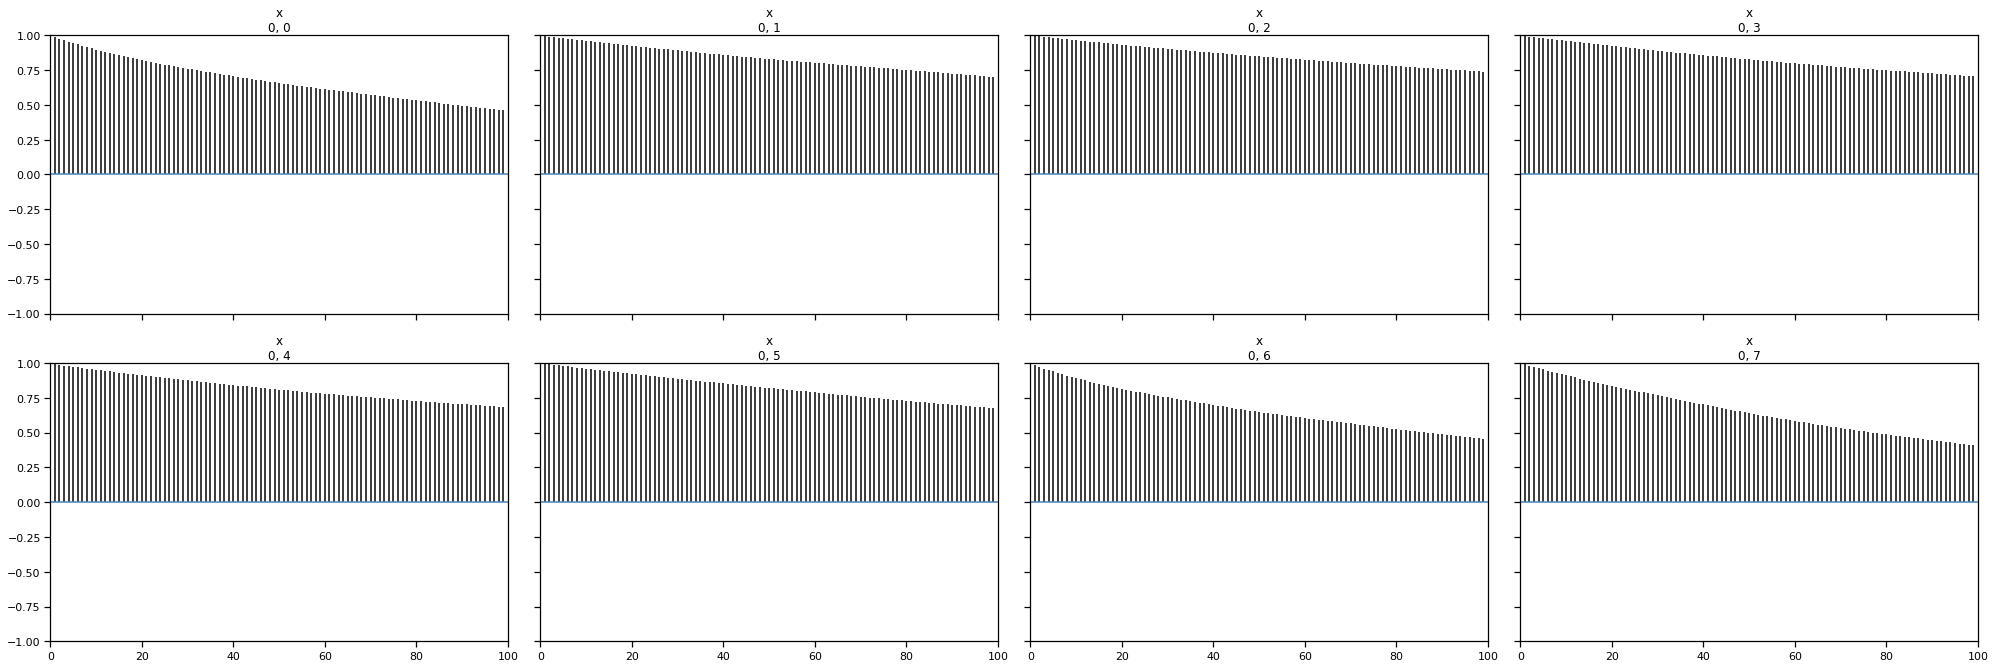

In [80]:
_ = az.plot_autocorr(ds)

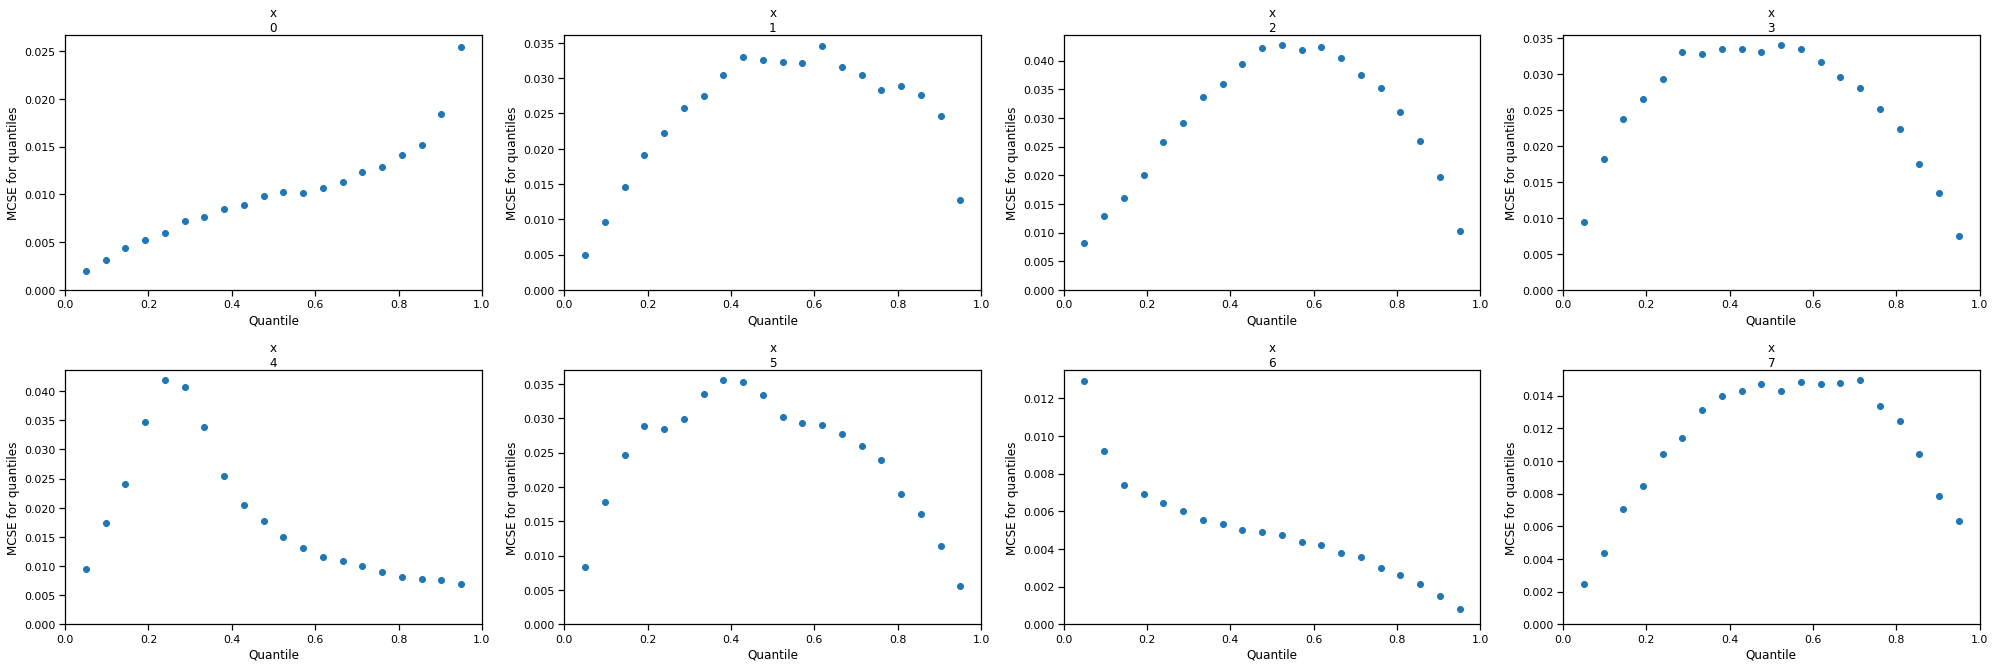

In [73]:
_ = az.plot_mcse(ds)

In [75]:
ds

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 80000, x_dim_0: 8)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 79994 79995 79996 79997 79998 79999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (chain, draw, x_dim_0) float32 0.17613171 0.05090337 ... 0.45758998
Attributes:
    created_at:  2020-02-09T19:15:49.038800

In [77]:
az.ess(ds)

<xarray.Dataset>
Dimensions:  (x_dim_0: 8)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    x        (x_dim_0) float64 233.9 172.7 114.6 160.0 149.7 175.3 238.1 351.1

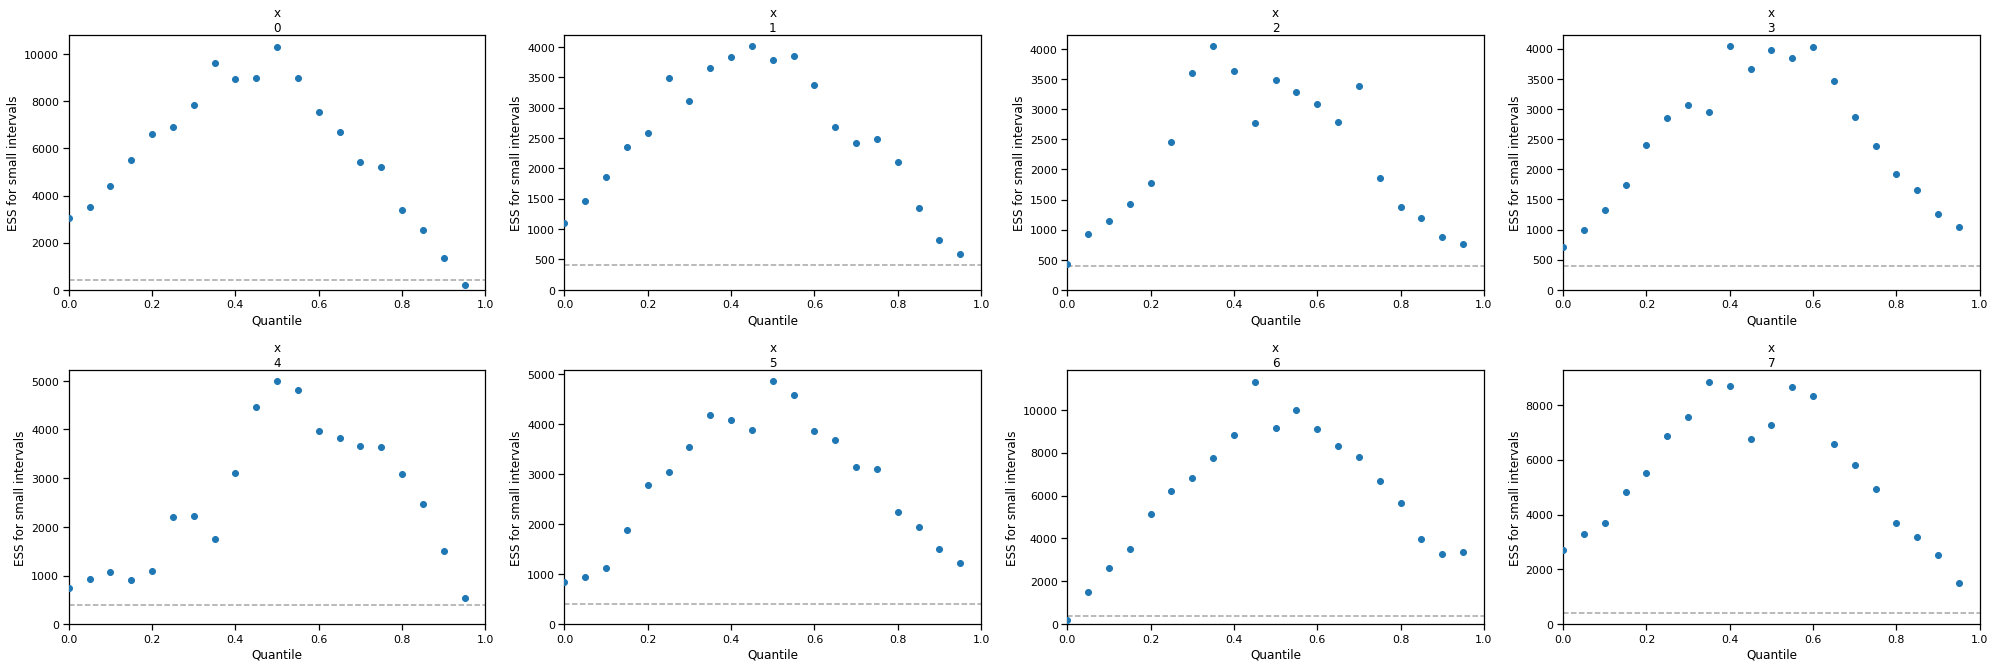

In [83]:
# Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space.
_ = az.plot_ess(ds, kind="local")

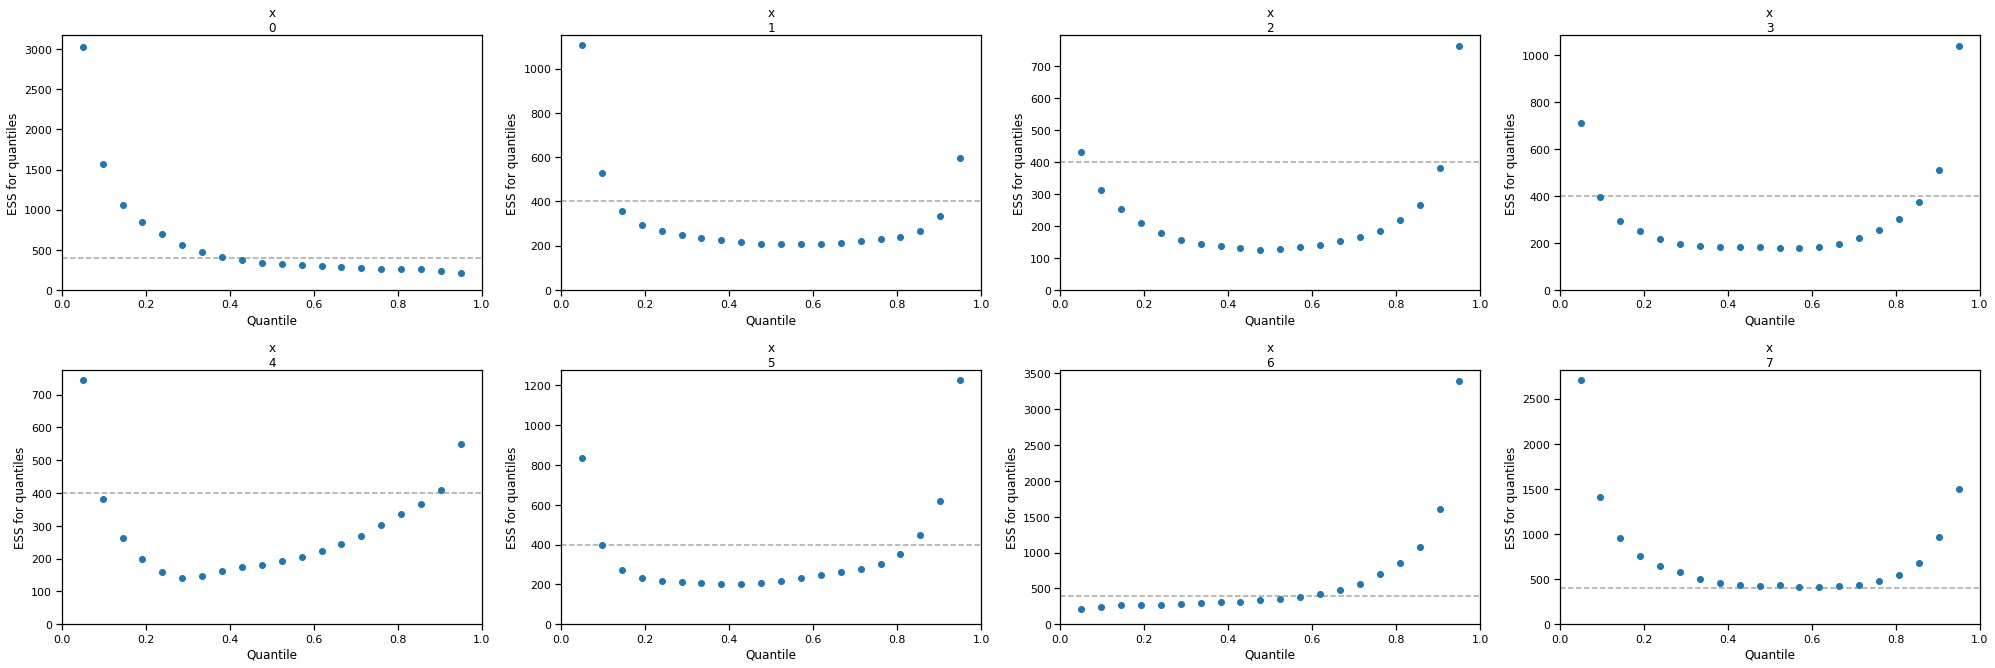

In [85]:
_ = az.plot_ess(ds, kind="quantile")

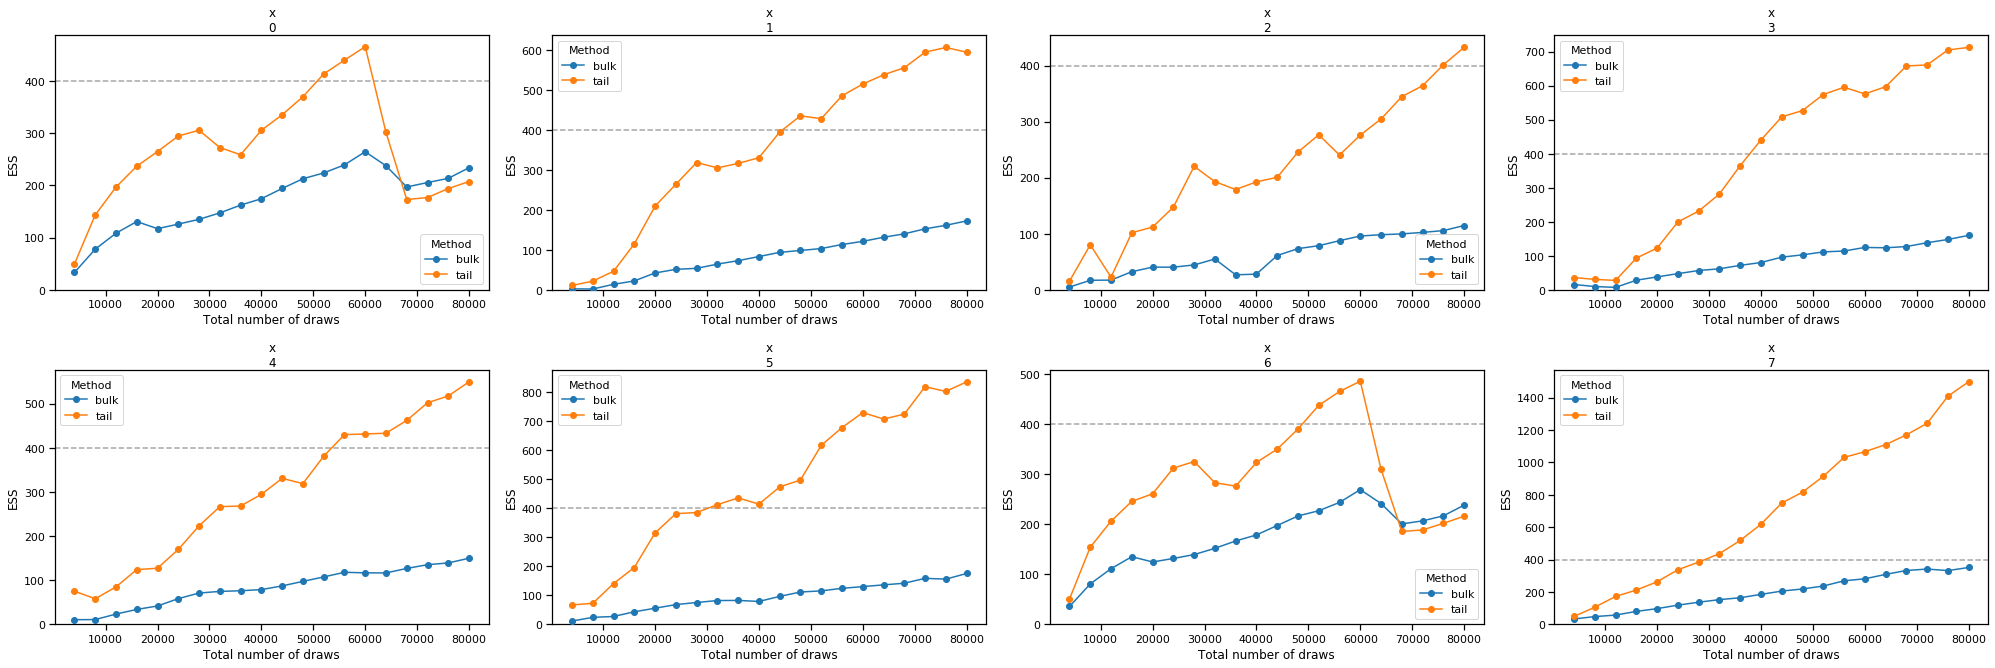

In [84]:
# Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
_ = az.plot_ess(ds, kind="evolution")